In [244]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas.util.testing as tm
from keras.datasets import mnist
import tensorflow_datasets as tfds
import tensorflow as tf
from google.colab import files
import sys
import itertools as it




In [10]:
#@title ElasticNetSubspaceClustering
import warnings
import progressbar
import spams
import time

from scipy import sparse
from sklearn import cluster
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.decomposition import sparse_encode
from sklearn.linear_model import orthogonal_mp
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize
from sklearn.utils import check_random_state, check_array, check_symmetric


class SelfRepresentation(BaseEstimator, ClusterMixin):

    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=20, n_jobs=1):
        self.n_clusters = n_clusters
        self.affinity = affinity
        self.random_state = random_state
        self.n_init = n_init
        self.n_jobs = n_jobs

    def fit(self, X, y=None):
        X = check_array(X, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64)
        time_base = time.time()
        
        self._self_representation(X)
        self.timer_self_representation_ = time.time() - time_base
        
        self._representation_to_affinity()
        self._spectral_clustering()
        self.timer_time_ = time.time() - time_base

        return self
	
    def fit_self_representation(self, X, y=None):
        X = check_array(X, accept_sparse=['csr', 'csc', 'coo'], dtype=np.float64)
        time_base = time.time()
        
        self._self_representation(X)
        self.timer_self_representation_ = time.time() - time_base
        
        return self

    def _representation_to_affinity(self):
        normalized_representation_matrix_ = normalize(self.representation_matrix_, 'l2')
        if self.affinity == 'symmetrize':
            self.affinity_matrix_ = 0.5 * (np.absolute(normalized_representation_matrix_) + np.absolute(normalized_representation_matrix_.T))
        elif self.affinity == 'nearest_neighbors':
            neighbors_graph = kneighbors_graph(normalized_representation_matrix_, 3, 
		                                       mode='connectivity', include_self=False)
            self.affinity_matrix_ = 0.5 * (neighbors_graph + neighbors_graph.T)

    def _spectral_clustering(self):
        affinity_matrix_ = check_symmetric(self.affinity_matrix_)
        random_state = check_random_state(self.random_state)
        
        laplacian = sparse.csgraph.laplacian(affinity_matrix_, normed=True)
        _, vec = sparse.linalg.eigsh(sparse.identity(laplacian.shape[0]) - laplacian, 
                                     k=self.n_clusters, sigma=None, which='LA')
        embedding = normalize(vec)
        _, self.labels_, _ = cluster.k_means(embedding, self.n_clusters, 
                                             random_state=random_state, n_init=self.n_init)


def active_support_elastic_net(X, y, alpha, tau=1.0, algorithm='spams', support_init='knn', 
                               support_size=100, maxiter=40):
    n_samples = X.shape[0]

    if n_samples <= support_size:  # skip active support search for small scale data
        supp = np.arange(n_samples, dtype=int)  # this results in the following iteration to converge in 1 iteration
    else:    
        if support_init == 'L2':
            L2sol = np.linalg.solve(np.identity(y.shape[1]) * alpha + np.dot(X.T, X), y.T)
            c0 = np.dot(X, L2sol)[:, 0]
            supp = np.argpartition(-np.abs(c0), support_size)[0:support_size]
        elif support_init == 'knn':
            supp = np.argpartition(-np.abs(np.dot(y, X.T)[0]), support_size)[0:support_size]

    curr_obj = float("inf")
    for _ in range(maxiter):
        Xs = X[supp, :]
        if algorithm == 'spams':
            cs = spams.lasso(np.asfortranarray(y.T), D=np.asfortranarray(Xs.T), 
                             lambda1=tau*alpha, lambda2=(1.0-tau)*alpha)
            cs = np.asarray(cs.todense()).T
        else:
            cs = sparse_encode(y, Xs, algorithm=algorithm, alpha=alpha)
      
        delta = (y - np.dot(cs, Xs)) / alpha
		
        obj = tau * np.sum(np.abs(cs[0])) + (1.0 - tau)/2.0 * np.sum(np.power(cs[0], 2.0)) + alpha/2.0 * np.sum(np.power(delta, 2.0))
        if curr_obj - obj < 1.0e-10 * curr_obj:
            break
        curr_obj = obj
			
        coherence = np.abs(np.dot(delta, X.T))[0]
        coherence[supp] = 0
        addedsupp = np.nonzero(coherence > tau + 1.0e-10)[0]
        
        if addedsupp.size == 0:  # converged
            break

        # Find the set of nonzero entries of cs.
        activesupp = supp[np.abs(cs[0]) > 1.0e-10]  
        
        if activesupp.size > 0.8 * support_size:  # this suggests that support_size is too small and needs to be increased
            support_size = min([round(max([activesupp.size, support_size]) * 1.1), n_samples])
        
        if addedsupp.size + activesupp.size > support_size:
            ord = np.argpartition(-coherence[addedsupp], support_size - activesupp.size)[0:support_size - activesupp.size]
            addedsupp = addedsupp[ord]
        
        supp = np.concatenate([activesupp, addedsupp])
    
    c = np.zeros(n_samples)
    c[supp] = cs
    return c

  
def elastic_net_subspace_clustering(X, gamma=50.0, gamma_nz=True, tau=1.0, algorithm='lasso_lars', 
                                    active_support=True, active_support_params=None, n_nonzero=50):
    if algorithm in ('lasso_lars', 'lasso_cd') and tau < 1.0 - 1.0e-10:  
        warnings.warn('algorithm {} cannot handle tau smaller than 1. Using tau = 1'.format(algorithm))
        tau = 1.0
		
    if active_support == True and active_support_params == None:
        active_support_params = {}

    n_samples = X.shape[0]
    rows = np.zeros(n_samples * n_nonzero)
    cols = np.zeros(n_samples * n_nonzero)
    vals = np.zeros(n_samples * n_nonzero)
    curr_pos = 0
 
    for i in progressbar.progressbar(range(n_samples)):
        y = X[i, :].copy().reshape(1, -1)
        X[i, :] = 0
        
        if algorithm in ('lasso_lars', 'lasso_cd', 'spams'):
            if gamma_nz == True:
                coh = np.delete(np.absolute(np.dot(X, y.T)), i)
                alpha0 = np.amax(coh) / tau  # value for which the solution is zero
                alpha = alpha0 / gamma
            else:
                alpha = 1.0 / gamma

            if active_support == True:
                c = active_support_elastic_net(X, y, alpha, tau, algorithm, **active_support_params)
            else:
                if algorithm == 'spams':
                    c = spams.lasso(np.asfortranarray(y.T), D=np.asfortranarray(X.T), 
                                    lambda1=tau * alpha, lambda2=(1.0-tau) * alpha)
                    c = np.asarray(c.todense()).T[0]
                else:
                    c = sparse_encode(y, X, algorithm=algorithm, alpha=alpha)[0]
        else:
          warnings.warn("algorithm {} not found".format(algorithm))
	    	  
        index = np.flatnonzero(c)
        if index.size > n_nonzero:
        #  warnings.warn("The number of nonzero entries in sparse subspace clustering exceeds n_nonzero")
          index = index[np.argsort(-np.absolute(c[index]))[0:n_nonzero]]
        rows[curr_pos:curr_pos + len(index)] = i
        cols[curr_pos:curr_pos + len(index)] = index
        vals[curr_pos:curr_pos + len(index)] = c[index]
        curr_pos += len(index)
        
        X[i, :] = y

#   affinity = sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples)) + sparse.csr_matrix((vals, (cols, rows)), shape=(n_samples, n_samples))
    return sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))
class ElasticNetSubspaceClustering(SelfRepresentation):
    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=20, n_jobs=1, gamma=50.0, gamma_nz=True, tau=1.0, 
                 algorithm='lasso_lars', active_support=True, active_support_params=None, n_nonzero=50):
        self.gamma = gamma
        self.gamma_nz = gamma_nz
        self.tau = tau
        self.algorithm = algorithm
        self.active_support = active_support
        self.active_support_params = active_support_params
        self.n_nonzero = n_nonzero

        SelfRepresentation.__init__(self, n_clusters, affinity, random_state, n_init, n_jobs)
    
    def _self_representation(self, X):
        self.representation_matrix_ = elastic_net_subspace_clustering(X, self.gamma, self.gamma_nz, 
                                                                      self.tau, self.algorithm, 
		                                                              self.active_support, self.active_support_params, 
		                                                              self.n_nonzero)
					

def sparse_subspace_clustering_orthogonal_matching_pursuit(X, n_nonzero=10, thr=1.0e-6):
    n_samples = X.shape[0]
    rows = np.zeros(n_samples * n_nonzero, dtype = int)
    cols = np.zeros(n_samples * n_nonzero, dtype = int)
    vals = np.zeros(n_samples * n_nonzero)
    curr_pos = 0

    for i in progressbar.progressbar(range(n_samples)):
    # for i in range(n_samples):
        residual = X[i, :].copy()  # initialize residual
        supp = np.empty(shape=(0), dtype = int)  # initialize support
        residual_norm_thr = np.linalg.norm(X[i, :]) * thr
        for t in range(n_nonzero):  # for each iteration of OMP  
            # compute coherence between residuals and X     
            coherence = abs( np.matmul(residual, X.T) )
            coherence[i] = 0.0
            # update support
            supp = np.append(supp, np.argmax(coherence))
            # compute coefficients
            c = np.linalg.lstsq( X[supp, :].T, X[i, :].T, rcond=None)[0]
            # compute residual
            residual = X[i, :] - np.matmul(c.T, X[supp, :])
            # check termination
            if np.sum(residual **2) < residual_norm_thr:
                break

        rows[curr_pos:curr_pos + len(supp)] = i
        cols[curr_pos:curr_pos + len(supp)] = supp
        vals[curr_pos:curr_pos + len(supp)] = c
        curr_pos += len(supp)

#   affinity = sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples)) + sparse.csr_matrix((vals, (cols, rows)), shape=(n_samples, n_samples))
    return sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))
					

class SparseSubspaceClusteringOMP(SelfRepresentation):
    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=10, n_jobs=1, n_nonzero=10, thr=1.0e-6):
        self.n_nonzero = n_nonzero
        self.thr = thr
        SelfRepresentation.__init__(self, n_clusters, affinity, random_state, n_init, n_jobs)
    
    def _self_representation(self, X):
        self.representation_matrix_ = sparse_subspace_clustering_orthogonal_matching_pursuit(X, self.n_nonzero, self.thr)


def least_squares_subspace_clustering(X, gamma=10.0, exclude_self=False):
    n_samples, n_features = X.shape
  
    if exclude_self == False:
        if n_samples < n_features:
            gram = np.matmul(X, X.T)
            return np.linalg.solve(gram + np.eye(n_sample) / gamma, gram).T
        else:
            tmp = np.linalg.solve(np.matmul(X.T, X) + np.eye(n_features) / gamma, X.T)
            return np.matmul(X, tmp).T
    else:
        if n_samples < n_features:
            D = np.linalg.solve(np.matmul(X, X.T) + np.eye(n_sample) / gamma, np.eye(n_sample))  
            # see Theorem 6 in https://arxiv.org/pdf/1404.6736.pdf
        else:
            tmp = np.linalg.solve(np.matmul(X.T, X) + np.eye(n_features) / gamma, X.T)
            D = eye(n_samples) - np.matmul(X, tmp)
        D = D / D.diagonal()[None,:]
        np.fill_diagonal(D, 0.0)
        return -1.0 * D.T
class LeastSquaresSubspaceClustering(SelfRepresentation):
    def __init__(self, n_clusters=8, affinity='symmetrize', random_state=None, n_init=None, n_jobs=1, gamma=10.0, exclude_self=False):
        self.gamma = gamma
        self.exclude_self = exclude_self
        SelfRepresentation.__init__(self, n_clusters, affinity, random_state, n_init, n_jobs)
    
    def _self_representation(self, X):
        self.representation_matrix_ = least_squares_subspace_clustering(X, self.gamma, self.exclude_self)     

**Real Data Analysis. Read, make diagnostic plots and cluster a real dataset**

Download the fashion MNIST:

In [43]:
if 'google.colab' in sys.modules:
    uploaded = files.upload()

Saving fashion-mnist_train.csv to fashion-mnist_train.csv


In [60]:
#subtract the mean from every class
def preprocess_substract_mean(X, y):
    labels = np.unique(y)
    X_processed= X.copy()
    for l in labels:
        mean = np.average(X_processed[y == l], 0)
        X_processed[y == l] = X_processed[y == l]- mean
    return X_processed


def q_a(X,y):
#Run PCA on the dataset and plot the projection on the first 2 principal components, with each class marked in a different color/symbol
    X_train_processed = preprocess_substract_mean(X, y)
    pca = PCA(2)  # project from 64 to 2 dimensions
    projected = pca.fit_transform(X_train_processed)
    #print(X_train_processed)
    #print(projected.shape)
    plt.scatter(projected[:, 0], projected[:, 1],
                c=y_train, edgecolor='none', alpha=0.5,
                cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    # plt.colorbar();
    plt.show()





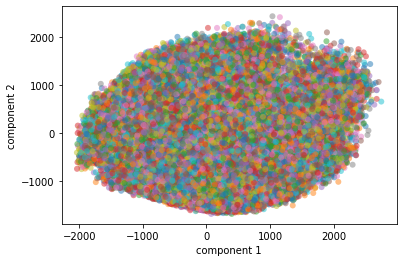

In [61]:
q_a(X_train,y_train)

**Are the classes well-separated?**

the PCA clustering with 2 component isn't seem well-separeted. 

In [180]:
def angle_calucalte(p1, p2):
    p1_u = p1 / np.linalg.norm(p1)
    p2_u = p2 / np.linalg.norm(p2)
    return (np.arccos(np.clip(np.dot(p1_u, p2_u), -1.0, 1.0)))

In [184]:

def q_b(X,y):
    # Sample at least 5000 pairs of points from the same class and 5000 pairs of points from different classes,
    labels = np.unique(y)
    n=5000
    cos_theta_in_all = np.empty( shape=(0, 0) )
    cos_theta_out_all = np.empty( shape=(0, 0) )
    num_labels = len(labels)
    rand_indx1 = random.choices(range(len(X)), k=int(n))
    rand_indx2 = list(pd.Series(rand_indx1).apply(lambda x: random.choices(Y.index[Y ==Y[x]])))
    rand_indx2 = [j[0] for j in rand_indx2]
    rand_indx3 = list(pd.Series(rand_indx1).apply(lambda x: random.choices(Y.index[Y !=Y[x]])))
    rand_indx3 = [j[0] for j in rand_indx3]
    points_in_1 = X_train.iloc[rand_indx1,:]
    points_in_2 = X_train.iloc[rand_indx2,:]
    points_out_1 = X_train.iloc[rand_indx3,:]
    #compute the angle between every pair of points
    theta_in_all =  [angle_calucalte(points_in_1.iloc[i,:],points_in_2.iloc[i,:]) for i in range(len(points_in_1))]
    theta_out_all = [angle_calucalte(points_in_1.iloc[i,:],points_out_1.iloc[i,:]) for i in range(len(points_in_1))]
    # Plot the distribution of between-cluster angles and within cluster angles.
    sns.distplot(theta_in_all,hist=True)
    sns.distplot(theta_out_all,hist=True)
    plt.legend(labels=['theta in', 'theta out'])
    plt.show()





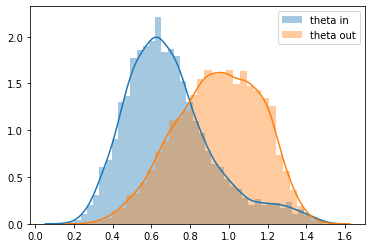

In [185]:
q_b(X_train,y_train)

**Do you see a difference between the distributions?**

Yes. the "within" distribution is less scattered and performs smaller mean both have a tail but for different sizes 

In [ ]:
l=5
pca = PCA() 
pca.fit_transform(X_train)
#print(pca.explained_variance_ratio_.round(3))

np.cumsum(pca.explained_variance_ratio_).round(3)

In [218]:
def q_c(X,y):
    # Perform PCA for each class separately, and plot for each class the proportion of variance explained vs the number of components ordered from the first PC until the last.
    
    # What number of components would you take for further analysis?
    labels = np.unique(y)
    #fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()
    for l in labels:
        pca = PCA() 
        pca.fit_transform(X[y==l])
        exp_var_ratio = pca.explained_variance_ratio_
        #ax1.plot(exp_var_ratio,label=f'class {l}')
        ax2.plot(np.cumsum(pca.explained_variance_ratio_),label=f'class {l}')
    #ax1.set_title("Explained Variance per class")
    ax2.set_title("Cumulated Explained Variance per class")
    #ax1.legend()
    ax2.legend()
    #fig1.show()
    fig2.show()
    #  Repeat but now with PCA for the entire dataset
    #fig3, ax3 = plt.subplots()
    fig4, ax4 = plt.subplots()
    pca = PCA()  
    projected = pca.fit_transform(X)
    exp_var_ratio = pca.explained_variance_ratio_
    #x3.plot(exp_var_ratio)
    ax4.plot(np.cumsum(exp_var_ratio))
    #ax3.set_title("Explained Variance Global")
    ax4.set_title("Cumulated Explained Variance Global")
    #fig3.show()
    fig4.show()

  




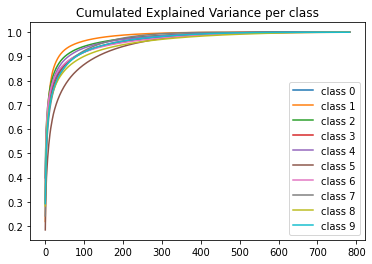

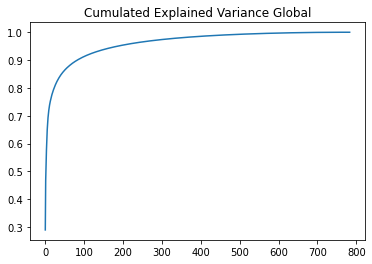

In [219]:
q_c(X_train,Y_train)

In [235]:
#What number of components would you take for further analysis?
pca = PCA(0.9)
pca.fit_transform(X_train)
print(f"The number of components necessary to explain 90% of the data is : {pca.n_components_}")


The number of components necessary to explain 90% of the data is : 84


In [225]:
def performance_measure2(k,cluster1,cluster2):
  data = {'cluster1': cluster1,'cluster2': cluster2} 
  clusters = pd.DataFrame(data, index=range(len(cluster1)))
  all_per = list(it.permutations(range(k)))
  accuracy_rate_all_per = np.zeros(len(all_per))
  for l, per in enumerate(all_per) :
    c = [i for i in range(k)]
    dic = dict(zip(c,per))
    clusters['premut_cluster'] = clusters['cluster2'].transform(lambda x: dic[x] if x in dic else None)
    m = clusters.groupby(['cluster1','premut_cluster']).size().unstack(fill_value=0)
    accuracy_rate_all_per[l]=np.trace(m)
  cost_cluster = (accuracy_rate_all_per.max())/len(cluster1) 
  return (cost_cluster) 

In [241]:

num_components = 85
pca =PCA(num_components)
pca_X =pca.fit_transform(X_train)
kmeans_after_PCA = KMeans(n_clusters=10).fit(pca_X)
kmeans_after_PCA.labels_

array([7, 2, 0, ..., 6, 6, 9], dtype=int32)

In [ ]:
a,b

In [242]:

def q_d(X,y):
    #Run the following algorithms on your dataset:

    
    #For each algorithm, compute and report the clustering accuracy from eq. (6). Explain your results.
    labels = np.unique(y)

    K=10
    #i. K-means with K = 10
    kmeans = KMeans(n_clusters=K).fit(X)
    kmeans_acc = performance_measure2(K,Y_train,kmeans.labels_)
    
    

    #ii. PCA with the number of components chosen based on (c.), followed by K-means with K = 10 on the projection to the top components.
    num_components = PCA(0.9).n_components_
    pca =PCA(num_components)
    pca_X =pca.fit_transform(X)
    kmeans_after_PCA = KMeans(n_clusters=K).fit(pca_X)
    kmeans_after_PCA.labels_
    kmeans_pca_acc  = performance_measure2(K,Y_train,kmeans_after_PCA.labels_)

    #iii. A subspace clustering algorithm of your choice (ENsc), where you can set the number of clusters to the correct one, 10.
    model_ensc = ElasticNetSubspaceClustering(n_clusters=K, algorithm='spams', gamma=500)
    ensc_acc = performance_measure2(K,Y_train,model_ensc.fit(X).lables_)
    print(f'kmeans acc is: {kmeans_acc} , pca followed by kmeans acc is : {kmeans_pca_acc}, ensc acc is {ensc_acc}')




In [ ]:
q_d(X_train,y_train)

In [ ]:
def main():
    #X_train, y_train = load_mnist('data/fashion', kind='train')
    #X_test, y_test = load_mnist('data/fashion', kind='t10k')
    train_data = pd.read_csv('fashion-mnist_train.csv')
    X_train = train_data.drop('label', axis=1)
    y_train = train_data['label']

    #X_train =X_train.astype(np.uint)
    #y_train =y_train.astype(np.uint)
    #X_test = X_test.astype(np.uint)
    #y_test = y_test.astype(np.uint)
    q_a(X_train, y_train)
    q_b(X_train, y_train)
    q_c(X_train, y_train)
    q_d(X_train, y_train)

if __name__ == '__main__':
    main()